# Evolution of the 1D model implementation : with Bednarsek acidity equation

This notebook demonstrates the use of the AcidityBedModel, which implements the Bednarsek et al. (2022) linear mortality equation for ocean acidification effects on pteropods.


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from seapopym.configuration.acidity import (
    ForcingParameter,
)
from seapopym.configuration.acidity_bed import (
    AcidityBedConfiguration,
    FunctionalGroupParameter,
    FunctionalGroupUnit,
    FunctionalTypeParameter,
)
from seapopym.configuration.no_transport import (
    ForcingUnit,
    MigratoryTypeParameter,
)
from seapopym.model import AcidityBedModel
from seapopym.standard.coordinate_authority import (
    create_latitude_coordinate,
    create_layer_coordinate,
    create_longitude_coordinate,
    create_time_coordinate,
)
from seapopym.standard.units import StandardUnitsLabels


## Generating data for the 1D simulation

Let's generate some data for the 1D simulation. The AcidityBedModel requires temperature, primary production, and acidity data. The Bednarsek model uses a linear mortality equation based on these environmental variables.


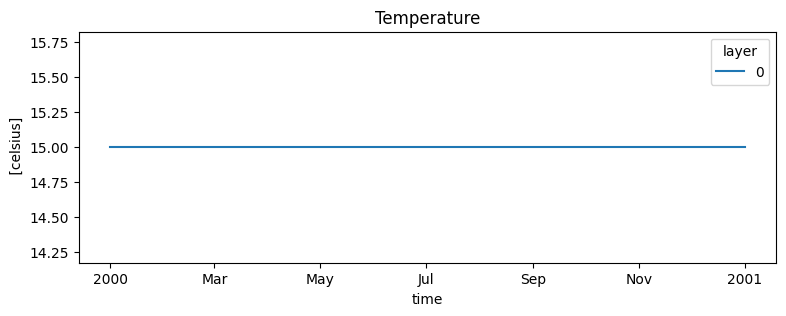

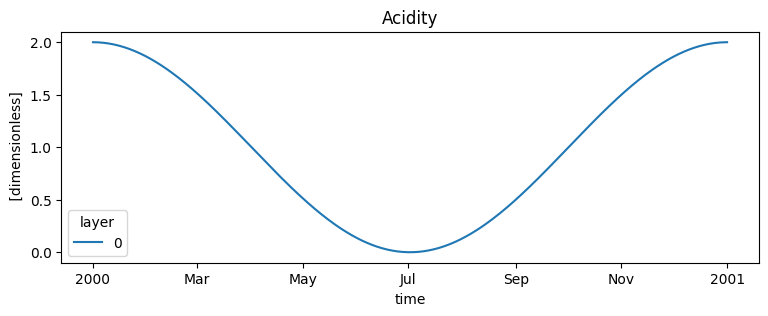

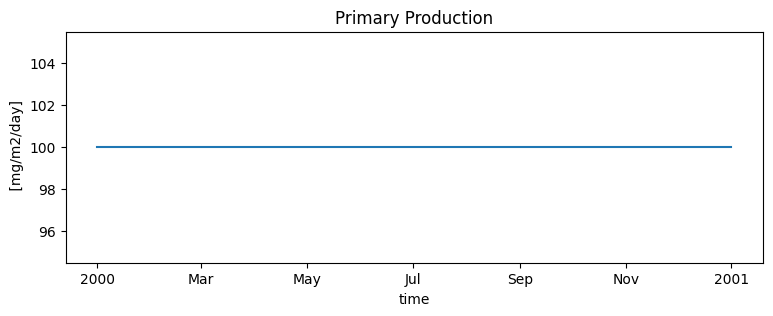

In [7]:
time_axis = create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D"))
n = int(time_axis.size)
t = np.linspace(0, 1, n)
temperature = np.ones_like(t) * 15
acidity = 1 + 1 * np.cos(2 * np.pi * t)

temperature = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.temperature},
    data=temperature[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
temperature[:, 0, 0].cf.plot.line(x="T")
plt.title("Temperature")
plt.show()

acidity = xr.DataArray(
    dims=["T", "Y", "X", "Z"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
        "Z": create_layer_coordinate([0]),
    },
    attrs={"units": StandardUnitsLabels.acidity},
    data=acidity[:, np.newaxis, np.newaxis, np.newaxis],
)

plt.figure(figsize=(9, 3))
acidity[:, 0, 0].cf.plot.line(x="T")
plt.title("Acidity")
plt.show()

primary_production = xr.DataArray(
    dims=["T", "Y", "X"],
    coords={
        "T": create_time_coordinate(pd.date_range("2000-01-01", "2001-01-01", freq="D")),
        "Y": create_latitude_coordinate([0]),
        "X": create_longitude_coordinate([0]),
    },
    attrs={"units": "mg/m2/day"},
    # data=np.random.rand(367, 1, 1),
    data=np.full((n, 1, 1), 100.0),
)

plt.figure(figsize=(9, 3))
primary_production.plot()
plt.title("Primary Production")
plt.show()

dataset = xr.Dataset({"temperature": temperature, "primary_production": primary_production, "acidity": acidity})

## Initialize the Bednarsek model

We set up the model parameters using the Bednarsek mortality equation. The key parameters are:

-   `lambda_0_bed`: Base mortality when T=0°C and aragonite=0
-   `gamma_lambda_temperature_bed`: Temperature sensitivity coefficient
-   `gamma_lambda_acidity_bed`: Aragonite/acidity sensitivity coefficient

The Bednarsek equation: mortality = lambda*0_bed + gamma_lambda_temperature_bed * T + gamma*lambda_acidity_bed * pH


In [8]:
day_layer = 0
night_layer = 0
tr_0 = 10.38
gamma_tr = -0.11

# Bednarsek mortality parameters
lambda_0_bed = -19.4
gamma_lambda_temperature_bed = 11.5
gamma_lambda_acidity_bed = -32.7

f_groups = FunctionalGroupParameter(
    functional_group=[
        FunctionalGroupUnit(
            name=f"Pteropod_D{day_layer}N{night_layer}",
            energy_transfert=0.1668,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_0_bed=lambda_0_bed,
                gamma_lambda_temperature_bed=gamma_lambda_temperature_bed,
                gamma_lambda_acidity_bed=gamma_lambda_acidity_bed,
                tr_0=tr_0,
                gamma_tr=gamma_tr,
            ),
        ),
        FunctionalGroupUnit(
            name=f"Pteropod_D{day_layer}N{night_layer}_BIS",
            energy_transfert=0.1668 / 2,
            migratory_type=MigratoryTypeParameter(day_layer=day_layer, night_layer=night_layer),
            functional_type=FunctionalTypeParameter(
                lambda_0_bed=lambda_0_bed / 2,
                gamma_lambda_temperature_bed=gamma_lambda_temperature_bed / 2,
                gamma_lambda_acidity_bed=gamma_lambda_acidity_bed / 2,
                tr_0=tr_0 / 2,
                gamma_tr=gamma_tr / 2,
            ),
        ),
    ]
)

p_param = ForcingParameter(
    temperature=ForcingUnit(forcing=dataset["temperature"]),
    primary_production=ForcingUnit(forcing=dataset["primary_production"]),
    acidity=ForcingUnit(forcing=dataset["acidity"]),
)

parameters = AcidityBedConfiguration(forcing=p_param, functional_group=f_groups)

primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.
primary_production unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.


## Run the Bednarsek model

The AcidityBedModel uses the linear Bednarsek mortality equation instead of the exponential equation used in the standard AcidityModel.


In [9]:
with AcidityBedModel.from_configuration(configuration=parameters) as bednarsek_model:
    bednarsek_model.state
    bednarsek_model.run()
    display(bednarsek_model.state)
    biomass = bednarsek_model.state["biomass"]

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:350: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  fill_value = asarray(fill_value)
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'cohort' ('cohort',) The recommendation is to set join explicitly for this case.
  return xr.concat(all_dataset, dim=coordinates, combine_attrs="no_conflicts")
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym/seapopym/configuration/no_transport/functional_group_parameter.py:258: FutureWarning: In a future version of xarray the defaul

<xarray.Dataset> Size: 59kB
Dimensions:                       (functional_group: 2, T: 367, Y: 1, X: 1,
                                   cohort: 11, Z: 1)
Coordinates:
  * functional_group              (functional_group) int64 16B 0 1
  * T                             (T) datetime64[ns] 3kB 2000-01-01 ... 2001-...
  * Y                             (Y) int64 8B 0
  * X                             (X) int64 8B 0
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * Z                             (Z) int64 8B 0
Data variables: (12/31)
    biomass                       (functional_group, T, Y, X) float64 6kB 0.0...
    recruited                     (functional_group, T, Y, X) float64 6kB 0.0...
    mortality_field               (functional_group, T, Y, X) float64 6kB 0.1...
    mask_temperature              (functional_group, T, Y, X, cohort) bool 8kB ...
    min_temperature               (functional_group, cohort) float64 176B 21....
    primary_production_by_fgroup  (functional_group, T, Y, X) float64 6kB 1.6...
    ...                            ...
    max_timestep                  (functional_group, cohort) float64 176B 1.0...
    mean_timestep                 (functional_group, cohort) float64 176B 1.0...
    timestep                      float64 8B 1.0
    angle_horizon_sun             float64 8B 0.0
    compute_initial_conditions    bool 1B False
    compute_preproduction         bool 1B False

## Plotting the results

### The biomass evolution over time using Bednarsek mortality equation

The linear Bednarsek equation provides a different mortality response to temperature and acidity compared to the exponential equation.


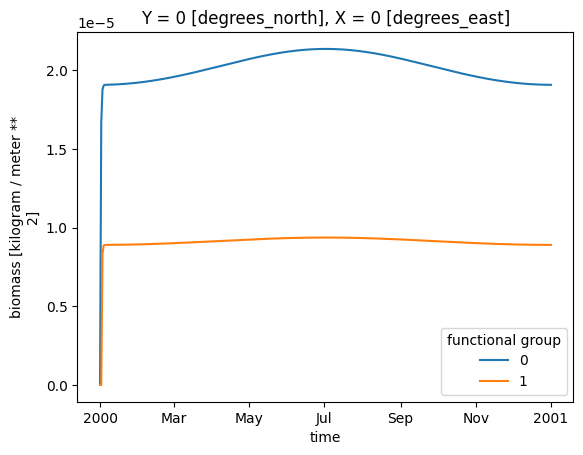

In [10]:
biomass.squeeze().plot.line(x="T", hue="functional_group")
